## NB4-Daily flow anaysis at HB14 gauges (only gauges on river network) <a id='top'></a>

Use 

    1. reach-HB14 gauge link ascii
    2. HB14 flow site shapefile
    3. HB14 discharge netCDF
    4. daily flow netCD (history file at only gauge) <case>.h.yyyy_daily_gauge.nc

[1. Setupt](#setup)

[2. Loading data and preprocess](#load_data)

- daily history files (directory from CESM or postprocessed) from archive. 

- Reference data is daily discharge estimates at xxxx big river mouths from Beck et al. 2014 data (HB14)

[3. Compute daily metrics at gauges](#Compute_metrics)

[4. Plot](#plot)

In [2]:
%matplotlib inline

import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression
from scipy import stats
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scripts.metrics as metrics
from scripts.utility import load_toml
from scripts.utility import reorder_index
from scripts.utility import AutoVivification

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])


The Python version: 3.10.12


-----
### dasks (optional)

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(queue='casper', memory='10GB', processes=1)
cluster.scale(jobs=5)

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [3]:
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:34675,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


-------------------------
## 1. Analysis setup <a id='setup'></a>

**Please provide CESM case names and ROF grid name**

[go back to top](#top)

In [3]:
# CESM case names and their runoff grid

cases = {
        'f09_f09_rHDMA':'rHDMA',
        'f09_f09_rHDMAlk_mg17':'rHDMAlk',
        'f09_f09_rHDMAlk_mg17_dfw':'rHDMAlk_dfw',
        #'f09_f09_rMERIT':'rMERIT',
        'f09_f09_mg17_mosart':'f09_f09_mosart',
        }

-------------------------
load config files and some parameters 

In [4]:
setup = load_toml('./setup/setup.toml')

main_dir       = setup['archive_dir']     # CESM archive directory
domain_dir     = setup['ancillary_dir']   # ancillary directory including such as ROF domain 
geospatial_dir = setup['ancillary_dir']   # including shapefiles etc
ancillary_dir  = setup['ancillary_dir']
ref_flow_dir   = setup['ref_flow_dir']    # including observed or reference flow data 
syr            = setup['syr']             # analysis start year
eyr            = setup['eyr']             # analysis end year
rof_grid       = setup['rof_grid']        # RO grid meta
reach_gpkg     = setup['reach_gpkg']      # reach geopackage meta

network = setup['river_network']

time_period = slice(f'{syr}-01-01',f'{eyr}-12-31') # analysis time period
nyrs = eyr-syr+1  # number of years
nmons = nyrs*12   # number of months

-------------------------
## 2. Loading data and preprocess <a id='load_data'></a>

[go back to top](#top)

### 2.1. Read simulated discharge data (at only gauge points)

In [6]:
%%time
reachID    = {}
daily_data = {}
for case, grid_name in cases.items():
    in_dire = os.path.join(main_dir, case, 'rof/hist')
    model  = rof_grid[grid_name]['model']
    #daily
    daily_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.HB14.nc', data_vars='minimal').sel(time=time_period).load()
        
    print(f"reading {case}...")

reading f09_f09_rHDMA...
reading f09_f09_rHDMAlk_mg17...
reading f09_f09_rHDMAlk_mg17_dfw...
reading f09_f09_mg17_mosart...
CPU times: user 5.9 s, sys: 1.83 s, total: 7.72 s
Wall time: 41 s


### 2.2 HB14 discharge data
- ds_q_obs_daily (xr datasets)

**open_dataset with decode_times=True outputs lazy loading, so need load method to bring the dataset into memory**

In [7]:
%%time
ds_q_obs_daily = xr.open_dataset('%s/HB14/HB14_daily_discharge.nc'%(ref_flow_dir), decode_times=True).sel(time=time_period).load()
ds_q_obs_daily = ds_q_obs_daily.sel(time=~((ds_q_obs_daily.time.dt.month == 2) & (ds_q_obs_daily.time.dt.day == 29)))
ds_q_obs_daily['time'] = xr.cftime_range(start=time_period.start, end=time_period.stop, freq="D", calendar="noleap")

CPU times: user 572 ms, sys: 375 ms, total: 947 ms
Wall time: 3.99 s


### 2.3 HB14 flow site shapefile
- gauge_shp (dataframe)

In [8]:
%%time
gauge_shp = gpd.read_file(os.path.join(ref_flow_dir, 'HB14','geospatial','HB14.shp'))
gauge_shp = gauge_shp[gauge_shp['id']!=9999999]

CPU times: user 2.29 s, sys: 15.3 ms, total: 2.31 s
Wall time: 2.48 s


### 2.4 Read river network netCDF
- riv_network (df)

In [9]:
reach_properties =['seg_id','upsArea']
riv_network = {}
for case, grid_name in cases.items():
    
    network_name = rof_grid[grid_name]['network']
    network_file = os.path.join(ancillary_dir, network[network_name]['file_name'])  # geopackage name
    
    ds_rn = xr.open_dataset(network_file)[reach_properties].set_index(seg='seg_id')
    riv_network[case] = ds_rn.to_dataframe()

    print(f"reading {network_file}...")

reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/postprocess+analysis//ancillary_data/ntopo_HDMA.v2.aug.nc...
reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/postprocess+analysis//ancillary_data/Network_topology_HDMA_HydroLake_v3_aug.nc...
reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/postprocess+analysis//ancillary_data/Network_topology_HDMA_HydroLake_v3_aug.nc...
reading /glade/u/home/mizukami/proj/ctsm-mizuRoute/postprocess+analysis//ancillary_data/mizuRoute_MOSART_Global_half_20161105a_aug.nc...


### 2.5. reach-HB14 gauge link csv
- gauge_reach_lnk (dataframe)
- ds_gauge (dataset)

In [10]:
gauge_reach_lnk = {}
ds_gauge ={}   # used for reorder
for case, grid_name in cases.items():
    gauge_reach_lnk[case] = pd.read_csv('%s/HB14/HB14.%s.asc'%(ref_flow_dir, rof_grid[grid_name]['network']))
    gauge_reach_lnk[case].rename(columns={"route_id": "reachID"}, inplace=True)
    
    #if case=='f09_f09_mg17':
        # temporal fix for f09_f09_mg17 run (simulation use 0 360 grid, but gauge-reach link use -180 180 grid
        #gauge_reach_lnk['f09_f09_mg17'].loc[gauge_reach_lnk['f09_f09_mg17']['gauge_lon']<0, 'route_id' ] = gauge_reach_lnk['f09_f09_mg17']['route_id'] + 360
        #gauge_reach_lnk['f09_f09_mg17'].loc[gauge_reach_lnk['f09_f09_mg17']['gauge_lon']>0, 'route_id' ] = gauge_reach_lnk['f09_f09_mg17']['route_id'] - 360

    # remove headwater gauges
    df_tmp = pd.merge(gauge_reach_lnk[case], riv_network[case], left_on='reachID', right_index=True)
    gauge_reach_lnk[case] = df_tmp.loc[df_tmp['upsArea'] > 0.0] 
    print('%s: %d -> %d after headwater removed'%(case, len(df_tmp), len(gauge_reach_lnk[case])))

    ds_gauge[case] = gauge_reach_lnk[case][['gauge_id','reachID']].set_index('gauge_id').to_xarray()
    ds_gauge[case] = ds_gauge[case].rename({'gauge_id':'gauge'},)

f09_f09_rHDMA: 8412 -> 6298 after headwater removed
f09_f09_rHDMAlk_mg17: 8409 -> 6234 after headwater removed
f09_f09_rHDMAlk_mg17_dfw: 8409 -> 6234 after headwater removed
f09_f09_mg17_mosart: 1476 -> 1270 after headwater removed


**If there are more than 1 cases, find common gauges among all the networks**

- gauge_reach_lnk_common
- ds_gauge_common (dataset)

In [11]:
if len(cases)>1:
    case_gauge_list = [gauge_reach_lnk[case]['gauge_id'].values for case in cases.keys()]
    common_gauge = list(set(case_gauge_list[0]).intersection(*case_gauge_list))

    gauge_reach_lnk_common = {}
    ds_gauge_common ={}
    
    for ix, case in enumerate(cases.keys()):
        gauge_reach_lnk_common[case] = gauge_reach_lnk[case][gauge_reach_lnk[case]["gauge_id"].isin(common_gauge)]
        ds_gauge_common[case] = ds_gauge[case].where(ds_gauge[case].gauge.isin(common_gauge), drop=True)
        if ix == 0:
            gauge_id_network_common = gauge_reach_lnk_common[case]['gauge_id'].values
        else:
            if not ((gauge_id_network_common - gauge_reach_lnk_common[case]['gauge_id'].values)==0).all():
                print('common gauge id inconsistency')

### 2.6 Subset simulated flow data and observed flow data at common gauges

In [12]:
# Extract only at common gauge
reach_id_network_common = {}
daily_data_common = {}
for case, grid_name in cases.items():
    daily_data_common[case] = daily_data[case].where(daily_data[case]['reachID'].isin(gauge_reach_lnk_common[case]['reachID']), drop=True)
    reach_id_network_common[case] = daily_data_common[case].reachID.values

In [13]:
%%time
# observed discharge subset
daily_q_obs_daily_network = {}
for case, grid_name in cases.items():
    daily_q_obs_daily_network[case] = ds_q_obs_daily.sel(gauge=ds_gauge[case].gauge)
    
ds_q_obs_daily_common = ds_q_obs_daily.sel(gauge=gauge_id_network_common)

CPU times: user 417 ms, sys: 67.9 ms, total: 485 ms
Wall time: 526 ms


### 2.7 Reorder sim and obs to match up with ds_gage


For gauge resolving individual networks
- daily_data
- ds_q_obs_daily

In [14]:
%%time
for case, grid_name in cases.items():

    remap_order = reorder_index(daily_data[case]['reachID'].values, ds_gauge[case]['reachID'].values)
    # Reorder pio according to the orginal
    daily_data[case] = daily_data[case].isel(dict(seg=remap_order))

    remap_order = reorder_index(daily_q_obs_daily_network[case]['gauge'].values, ds_gauge[case]['gauge'].values)
    # Reorder pio according to the orginal
    daily_q_obs_daily_network[case] = daily_q_obs_daily_network[case].isel(dict(gauge=remap_order))

CPU times: user 1.76 s, sys: 372 ms, total: 2.13 s
Wall time: 2.22 s


For common gauge resolving all the networks
- daily_data_common
- ds_q_obs_daily_common

In [15]:
%%time
for case, grid_name in cases.items():

    remap_order = reorder_index(daily_data_common[case]['reachID'].values, ds_gauge_common[case]['reachID'].values)
    # Reorder pio according to the orginal
    daily_data_common[case] = daily_data_common[case].isel(dict(seg=remap_order))

remap_order = reorder_index(ds_q_obs_daily_common['gauge'].values, ds_gauge_common[case]['gauge'].values)
# Reorder pio according to the orginal
ds_q_obs_daily_common = ds_q_obs_daily_common.isel(dict(gauge=remap_order))

CPU times: user 97.9 ms, sys: 72.5 ms, total: 170 ms
Wall time: 189 ms


----
some checks. should get all **True**

In [16]:
((daily_data_common['f09_f09_rHDMA']['reachID'].values - ds_gauge_common['f09_f09_rHDMA']['reachID'].values)==0).all()

True

In [17]:
((ds_q_obs_daily_common['gauge']- ds_gauge_common['f09_f09_mg17_mosart']['gauge'])==0).values.all()

True

In [18]:
((ds_gauge_common['f09_f09_rHDMA']['gauge'] - ds_gauge_common['f09_f09_mg17_mosart']['gauge'])==0).values.all()

True

-------------------------
## 3. Compute daily metrics (correlation, MEA, pbias) at gauges <a id='Compute_metrics'></a>

[go back to top](#top)

**use all the guages available for each network**

In [19]:
%%time

daily_metrics = AutoVivification()

for case, grid_name in cases.items():

    q_name=rof_grid[grid_name]['flow_name']
    
    ngauge = len(ds_gauge[case].gauge)
    
    corr_array  = np.full(ngauge, np.nan, dtype=float)
    mae_array   = np.full(ngauge, np.nan, dtype=float)
    pbias_array = np.full(ngauge, np.nan, dtype=float)
    
    for ix in np.arange(ngauge):
        mae_value   = metrics.mae(daily_data[case][q_name][:,ix].values, daily_q_obs_daily_network[case]['daily_discharge'][:,ix].values)
        corr_value  = metrics.corr(daily_data[case][q_name][:,ix].values, daily_q_obs_daily_network[case]['daily_discharge'][:,ix].values)
        pbias_value = metrics.pbias(daily_data[case][q_name][:,ix].values, daily_q_obs_daily_network[case]['daily_discharge'][:,ix].values)
        
        if np.isinf(mae_value):
            mae_value = np.nan
        if np.isinf(corr_value):
            corr_value = np.nan
        if np.isinf(pbias_value):
            pbias_value = np.nan
            
        corr_array[ix]  = corr_value
        mae_array[ix]   = mae_value
        pbias_array[ix] = pbias_value
        
    daily_metrics[case]['corr']  = corr_array
    daily_metrics[case]['mae']   = mae_array
    daily_metrics[case]['pbias'] = pbias_array

/glade/u/home/mizukami/proj/ctsm-mizuRoute/postprocess+analysis/notebook/scripts/metrics.py:36: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum((abs(qsim1-qobs1)))/np.sum(qobs1)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/numpy/lib

CPU times: user 40 s, sys: 229 ms, total: 40.2 s
Wall time: 42.8 s


**Only at common gauges across different networks**

In [20]:
%%time

daily_metrics_common = AutoVivification()
ngauge = len(gauge_id_network_common)

for case, grid_name in cases.items():

    q_name=rof_grid[grid_name]['flow_name']
    
    corr_array = np.full(ngauge, np.nan, dtype=float)
    mae_array  = np.full(ngauge, np.nan, dtype=float)
    pbias_array = np.full(ngauge, np.nan, dtype=float)
    
    for ix in np.arange(ngauge):
        mae_value   = metrics.mae  (daily_data_common[case][q_name][:,ix].values, ds_q_obs_daily_common['daily_discharge'][:,ix].values)
        corr_value  = metrics.corr (daily_data_common[case][q_name][:,ix].values, ds_q_obs_daily_common['daily_discharge'][:,ix].values)
        pbias_value = metrics.pbias(daily_data_common[case][q_name][:,ix].values, ds_q_obs_daily_common['daily_discharge'][:,ix].values)
        
        if np.isinf(mae_value):
            mae_value = np.nan
        if np.isinf(corr_value):
            corr_value = np.nan
        if np.isinf(pbias_value):
            pbias_value = np.nan
            
        corr_array[ix] = corr_value
        mae_array[ix] = mae_value
        pbias_array[ix] = pbias_value
        
    daily_metrics_common[case]['corr']  = corr_array
    daily_metrics_common[case]['mae']   = mae_array
    daily_metrics_common[case]['pbias'] = pbias_array

CPU times: user 9.1 s, sys: 56.1 ms, total: 9.15 s
Wall time: 9.56 s


-------------------------
## 4. plots <a id='plot'></a>

[go back to top](#top)

### 4.1 Spatial map of daily correlation

In [21]:
# create colormaps

# for pbias
cmap1 = LinearSegmentedColormap.from_list('custom blue', 
                                           [(0,     'xkcd:red'),
                                            (0.05,  'xkcd:orange'),
                                            (0.31,  'xkcd:light grey'),
                                            (0.65,  'xkcd:sky blue'),
                                            (1,     'xkcd:blue')], N=15)
cmap1.set_under('xkcd:dark red')
cmap1.set_over('xkcd:dark blue')

# for correlation
cmap2 = LinearSegmentedColormap.from_list('custom blue', 
                                           [(0,     'xkcd:light sky blue'),
                                            (0.25,  'xkcd:cyan'),
                                            (0.75,  'xkcd:blue'),
                                            (1,     'xkcd:royal blue')], N=8)
cmap2.set_under('xkcd:gray')

# for correlation
cmap3 = LinearSegmentedColormap.from_list('custom blue', 
                                           [(0,     'xkcd:light sky blue'),
                                            (0.25,  'xkcd:cyan'),
                                            (0.75,  'xkcd:blue'),
                                            (1,     'xkcd:royal blue')], N=8)
cmap3.set_over('xkcd:dark blue')

# for difference
cmap4 = LinearSegmentedColormap.from_list('custom blue', 
                                           [(0,     'xkcd:blue'),
                                            (0.5,   'xkcd:light grey'),
                                            (1,     'xkcd:red')], N=8)
cmap4.set_under('xkcd:dark blue')
cmap4.set_over('xkcd:dark red')

In [22]:
# some local plot setups
cm = {
      'general': mpl.cm.turbo,
      'corr' :   cmap2,
      'pbias':   cmap1,
      'rmse':    cmap3,
      'mae':     cmap3,
      'diff':    cmap4,
     }

cbar_kwrgs = {
              'pbias': {"shrink":0.9, "pad":0.02, "orientation": "horizontal", 'extend':'both'},
              'corr':  {"shrink":0.9, "pad":0.02, "orientation": "horizontal", 'extend':'min'},
              'rmse':  {"shrink":0.9, "pad":0.02, "orientation": "horizontal", 'extend':'max'},
              'mae':   {"shrink":0.9, "pad":0.02, "orientation": "horizontal", 'extend':'max'},
              'diff':  {"shrink":0.9, "pad":0.02, "orientation": "horizontal", 'extend':'both'},
              }

meta = {
        'pbias':      {'vmin':-1,   'vmax':2,   'cm':cm['pbias']},
        'corr':       {'vmin':0.2,  'vmax':1,   'cm':cm['corr']},
        'rmse':       {'vmin':0,    'vmax':500, 'cm':cm['rmse']},
        'mae':        {'vmin':0,    'vmax':2,   'cm':cm['mae']},
        'mae_diff':   {'vmin':-1,   'vmax':1,   'cm':cm['diff']},
        'corr_diff':  {'vmin':-0.4, 'vmax':0.4, 'cm':cm['diff']},
        } 

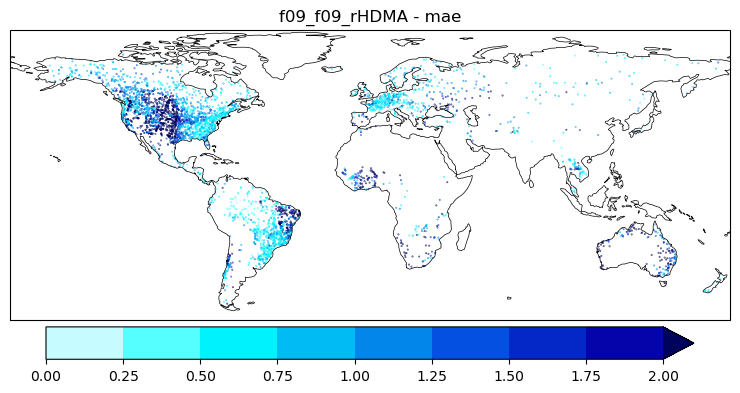

In [23]:
# map
case = 'f09_f09_rHDMA'
stat = 'mae'

if case=='f09_f09_mg17_mosart':
    ms=1.0
else:
    ms=0.1

fig = plt.figure(figsize=(7.5,4.0), dpi=100)
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())  
    
ax.set_global()
ax.coastlines(linewidth=0.5)

pval = daily_metrics[case][stat]
sc1 = ax.scatter(daily_q_obs_daily_network[case].gauge_lon, daily_q_obs_daily_network[case].gauge_lat, 
                 s=ms, c=pval, marker='o', cmap=meta[stat]['cm'], vmin=meta[stat]['vmin'], vmax=meta[stat]['vmax'], 
)
ax.set_extent([-180, 180, -60, 85])
ax.set_title(f'{case} - {stat}')

points = ax.collections[0]
plt.colorbar(points, ax=ax, **cbar_kwrgs[stat]);

plt.tight_layout()
plt.savefig(f"NB4_Fig1_daily_{stat}_{case}_map.png", dpi=200)

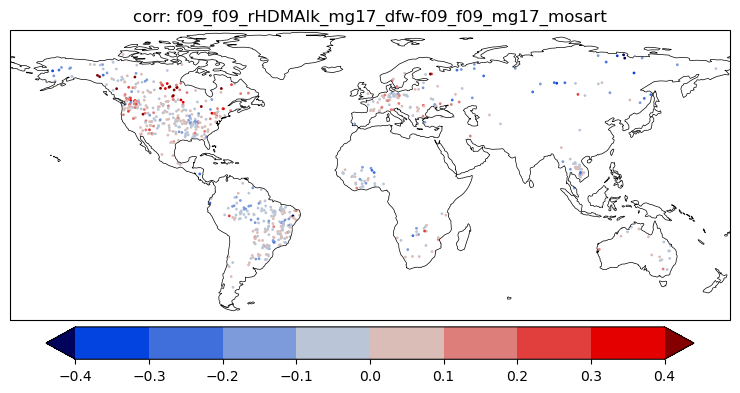

In [238]:
# map
base   = 'f09_f09_mg17_mosart'
target = 'f09_f09_rHDMAlk_mg17_dfw'
stat = 'corr'

if base=='f09_f09_mg17_mosart':
    ms=1.0
else:
    ms=0.2

fig = plt.figure(figsize=(7.5,4.0), dpi=100)
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())  
    
ax.set_global()
ax.coastlines(linewidth=0.5)

pval = daily_metrics_common[target][stat] - daily_metrics_common[base][stat]
sc1 = ax.scatter(ds_q_obs_daily_common.gauge_lon, ds_q_obs_daily_common.gauge_lat, 
                 s=ms, c=pval, marker='o', cmap=meta[f'{stat}_diff']['cm'], vmin=meta[f'{stat}_diff']['vmin'], vmax=meta[f'{stat}_diff']['vmax'], 
)
ax.set_extent([-180, 180, -60, 85])
ax.set_title(f'{stat}: {target}-{base}')

points = ax.collections[0]
plt.colorbar(points, ax=ax, **cbar_kwrgs['diff']);

plt.tight_layout()
#plt.subplots_adjust(bottom=0.25, right=0.9, top=0.9)
plt.savefig(f"NB4_Fig1_daily_{stat}_{target}_vs_{base}_map.png", dpi=200)

### 4.2 Summary plots for daily metrics
- boxplots
- cdf

median values across gauges
pbias_rHDMA             0.339373
pbias_rHDMAlk           0.325566
pbias_rHDMAlk_dfw       0.324463
pbias_f09_f09_mosart    0.302244
dtype: float64


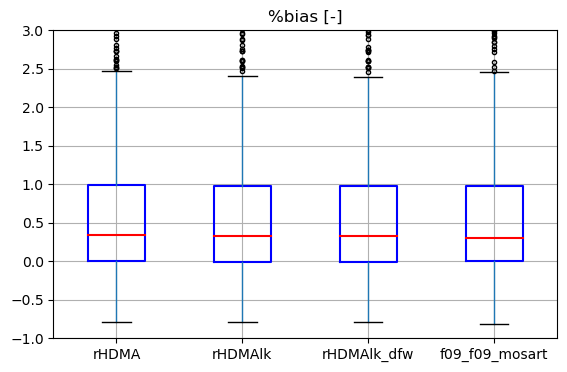

In [24]:
# boxplots

stat = 'pbias'

column_stat = []
ngauge = len(gauge_id_network_common)
stat_array  = np.full((ngauge,len(cases)), np.nan, dtype='float')
for ix, (case, grid_name) in enumerate(cases.items()):
    column_stat.append(f"{stat}_{grid_name}")
    stat_array[:,ix] = daily_metrics_common[case][stat]
df = pd.DataFrame(stat_array, columns=column_stat)

boxprops    = {'linestyle':'-', 'linewidth':1.5, 'color':'blue'}
medianprops = {'linestyle':'-', 'linewidth':1.5, 'color':'red'}

fig, ax = plt.subplots(1, figsize=(6.5,4))
df.boxplot(ax=ax, column=column_stat,
                       boxprops=boxprops, medianprops=medianprops, sym='.')

xticklabels = [label[len(stat)+1:] for label in column_stat]
ax.set_xticklabels(xticklabels)

if stat == 'mae':
    ax.set_ylim([0,2])
    ax.set_title('abs. mean error [-]');
elif stat=='pbias':
    ax.set_ylim([-1,3])
    ax.set_title('%bias [-]');
elif stat=='corr':
    ax.set_ylim([-0.1,1])
    ax.set_title('correlation');

print('median values across gauges')
print(df.median())
    
plt.savefig(f"./Figures/NB4_Fig2_daily_{stat}_boxplot.png", dpi=150)

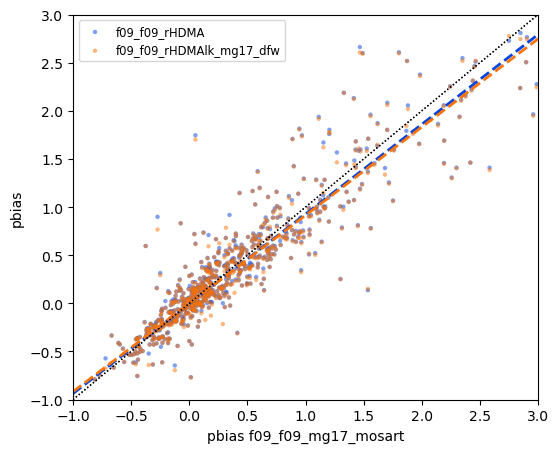

In [25]:
# scatter pot
stat = 'pbias'

base = 'f09_f09_mg17_mosart'
target = ['f09_f09_rHDMA','f09_f09_rHDMAlk_mg17_dfw']

fig, ax = plt.subplots(1, figsize=(6.0,5))

if stat=='mae':
    xmin = 0.0; xmax=2.0
elif stat=='corr':
    xmin = -0.2; xmax=1.0
elif stat=='pbias':
    xmin = -1.; xmax=3

metric_base = daily_metrics_common[base][stat]

for case in target:
    grid_name = cases[case]
    metric_value = daily_metrics_common[case][stat]
    plt.scatter(metric_base, metric_value, c=rof_grid[grid_name]['color'], label=f'{case}', marker='o', s=10, alpha=0.5, edgecolors='none')

    mask = ~np.isnan(metric_value) & ~np.isnan(metric_base)
    lr =  stats.linregress(metric_base[mask] , metric_value[mask])
    x=np.linspace(xmin,xmax, num=10, endpoint=True)
    ax.plot(x, lr.intercept + lr.slope*x, '--', lw=2, c=rof_grid[grid_name]['color'])
    ax.axline((1, 1), slope=1, color="k", lw=1, ls=':')
    
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(f'{stat} {base}')
plt.ylabel(f'{stat}')
plt.legend(fontsize='small');
plt.savefig(f"Figures/NB4_Fig3_daily_{stat}_scatter.png", dpi=150)

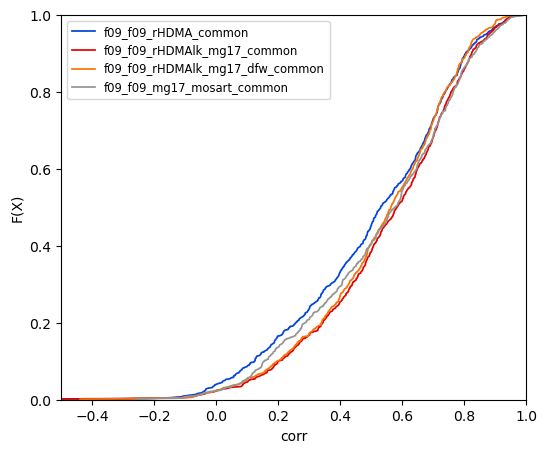

In [26]:
#cdf
stat = 'corr'

gage_sets = ['common']   # common or/and indiv_network

fig, ax = plt.subplots(1, figsize=(6.0,5))

if stat=='mae':
    xmin = 0; xmax=2
elif stat=='corr':
    xmin = -0.5; xmax=1.0
elif stat=='pbias':
    xmin = -1.; xmax=5

for case, grid_name in cases.items():
    for gage_set in gage_sets:
        if gage_set=='indiv_network':
            ls = '--'
            metric_value = daily_metrics[case][stat]
        if gage_set=='common':
            ls = '-'
            metric_value = daily_metrics_common[case][stat]
            
        metric_value = metric_value[~np.isnan(metric_value)]
        xdata_sort = np.sort(metric_value)
        prob_metric=np.arange(1,float(len(xdata_sort)+1))/(1+len(xdata_sort))
    
        plt.plot(xdata_sort, prob_metric, c=rof_grid[grid_name]['color'], ls=ls, label=f'{case}_{gage_set}', linewidth=1.25)
plt.xlim(xmin, xmax)
plt.ylim(0, 1)
plt.xlabel(f'{stat}')
plt.ylabel(f'F(X)')
plt.legend(fontsize='small');

plt.savefig(f"NB4_Fig4_daily_{stat}_cdf.png", dpi=150)